In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from scipy import stats

In [2]:
# Importing 13 weeks of MTA turnstile data from 2021-06-05 to 2021-09-04:
## Source: http://web.mta.info/developers/turnstile.html

def get_data(week_nums):
    url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
    df_list = []
    for week_num in week_nums:
        week_url = url.format(week_num)
        df_list.append(pd.read_csv(week_url))
    return pd.concat(df_list).reset_index()
    # reset_index() is necessary.

week_nums = [210612, 210619, 210626, 210703, 210710, 210717, 210724, 210731, 210807, 210814, 210821, 210828, 210904]
mta_df = get_data(week_nums)

In [3]:
mta_df.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,00:00:00,REGULAR,7581941,2591624
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,04:00:00,REGULAR,7581950,2591625
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,08:00:00,REGULAR,7581954,2591635
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,12:00:00,REGULAR,7582009,2591655
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,16:00:00,REGULAR,7582124,2591683


In [4]:
# Writing the concatenated datasets into a csv file to feed into a SQLite database:

mta_df.to_csv('mta_data_all.csv', header = False, index = False)

In [5]:
# Columns' names

mta_df.columns

Index(['index', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DATE', 'TIME', 'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [6]:
# Correcting columns' names

mta_df.columns = [column.strip() for column in mta_df.columns]

In [7]:
mta_df.columns

Index(['index', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [8]:
mta_df['DATE_TIME'] = pd.to_datetime(mta_df['DATE'] + ' ' + mta_df['TIME'])

In [9]:
mta_df.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,00:00:00,REGULAR,7581941,2591624,2021-06-05 00:00:00
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,04:00:00,REGULAR,7581950,2591625,2021-06-05 04:00:00
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,08:00:00,REGULAR,7581954,2591635,2021-06-05 08:00:00
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,12:00:00,REGULAR,7582009,2591655,2021-06-05 12:00:00
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,16:00:00,REGULAR,7582124,2591683,2021-06-05 16:00:00


In [10]:
# Combining the C/A, UNIT and SCP columns into one single column for ease of use:

mta_df['TURNSTILE'] = mta_df['C/A'] + '/' + mta_df['UNIT'] + '/' + mta_df['SCP']

In [11]:
mta_df.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TURNSTILE
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,00:00:00,REGULAR,7581941,2591624,2021-06-05 00:00:00,A002/R051/02-00-00
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,04:00:00,REGULAR,7581950,2591625,2021-06-05 04:00:00,A002/R051/02-00-00
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,08:00:00,REGULAR,7581954,2591635,2021-06-05 08:00:00,A002/R051/02-00-00
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,12:00:00,REGULAR,7582009,2591655,2021-06-05 12:00:00,A002/R051/02-00-00
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,16:00:00,REGULAR,7582124,2591683,2021-06-05 16:00:00,A002/R051/02-00-00


In [12]:
# Looking for duplicate rows: 
## rows with more than one reading per one combination of Turnstile, Station, Date and Time)

duplicates = mta_df[(mta_df['TURNSTILE']
 + mta_df['STATION']
 + mta_df['DATE']
 + mta_df['TIME']).duplicated(keep=False) == True]

In [13]:
duplicates.shape

(106, 14)

In [14]:
duplicates.STATION.unique()

array(['TREMONT AV', 'KEW GARDENS', 'ASTORIA BLVD', '61 ST WOODSIDE',
       '33 ST-RAWSON ST', 'CARROLL ST', 'ST. GEORGE'], dtype=object)

In [15]:
mta_df.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TURNSTILE
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,00:00:00,REGULAR,7581941,2591624,2021-06-05 00:00:00,A002/R051/02-00-00
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,04:00:00,REGULAR,7581950,2591625,2021-06-05 04:00:00,A002/R051/02-00-00
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,08:00:00,REGULAR,7581954,2591635,2021-06-05 08:00:00,A002/R051/02-00-00
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,12:00:00,REGULAR,7582009,2591655,2021-06-05 12:00:00,A002/R051/02-00-00
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,16:00:00,REGULAR,7582124,2591683,2021-06-05 16:00:00,A002/R051/02-00-00


### There are 106 rows with duplicate values meaning 53 data points (out of 2.7 million). As they are not in important stations across the subway system, they can safely be removed: 

In [16]:
mta_df.drop_duplicates(subset=['TURNSTILE', 'STATION', 'DATE', 'TIME'], keep=False, inplace=True)

In [17]:
# Resetting the df indices to take account for removed rows:

mta_df.reset_index(inplace=True)

In [18]:
# Removing the resetted indices columns:

mta_df.drop(columns=['level_0', 'index'], inplace=True)

In [19]:
mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TURNSTILE
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,00:00:00,REGULAR,7581941,2591624,2021-06-05 00:00:00,A002/R051/02-00-00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,04:00:00,REGULAR,7581950,2591625,2021-06-05 04:00:00,A002/R051/02-00-00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,08:00:00,REGULAR,7581954,2591635,2021-06-05 08:00:00,A002/R051/02-00-00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,12:00:00,REGULAR,7582009,2591655,2021-06-05 12:00:00,A002/R051/02-00-00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2021,16:00:00,REGULAR,7582124,2591683,2021-06-05 16:00:00,A002/R051/02-00-00


In [20]:
len(mta_df.TURNSTILE.unique())

5030

In [21]:
len(mta_df.STATION.unique())

379

### We have 5030 turnstiles across 379 stations!

### Now we find the difference between two consecutive counts for each turnstile:

In [22]:
# Sum of entries and exits cumulative values for each unique turnstile for each reading occasion:

mta_df_values = mta_df.groupby(['TURNSTILE', 'STATION', 'DATE_TIME','DATE', 'TIME'])[['ENTRIES', 'EXITS']].sum().reset_index()

In [23]:
mta_df_values.head()

,TURNSTILE,STATION,DATE_TIME,DATE,TIME,ENTRIES,EXITS
0,A002/R051/02-00-00,59 ST,2021-06-05 00:00:00,06/05/2021,00:00:00,7581941,2591624
1,A002/R051/02-00-00,59 ST,2021-06-05 04:00:00,06/05/2021,04:00:00,7581950,2591625
2,A002/R051/02-00-00,59 ST,2021-06-05 08:00:00,06/05/2021,08:00:00,7581954,2591635
3,A002/R051/02-00-00,59 ST,2021-06-05 12:00:00,06/05/2021,12:00:00,7582009,2591655
4,A002/R051/02-00-00,59 ST,2021-06-05 16:00:00,06/05/2021,16:00:00,7582124,2591683


In [24]:
# Calculating the difference:

mta_df_values[['ENTRIES_DIFF', 'EXITS_DIFF']] = mta_df_values.groupby(['TURNSTILE'])[['ENTRIES', 'EXITS']].diff()

In [25]:
mta_df_values.head()

,TURNSTILE,STATION,DATE_TIME,DATE,TIME,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
0,A002/R051/02-00-00,59 ST,2021-06-05 00:00:00,06/05/2021,00:00:00,7581941,2591624,NaN,NaN
1,A002/R051/02-00-00,59 ST,2021-06-05 04:00:00,06/05/2021,04:00:00,7581950,2591625,9.0,1.0
2,A002/R051/02-00-00,59 ST,2021-06-05 08:00:00,06/05/2021,08:00:00,7581954,2591635,4.0,10.0
3,A002/R051/02-00-00,59 ST,2021-06-05 12:00:00,06/05/2021,12:00:00,7582009,2591655,55.0,20.0
4,A002/R051/02-00-00,59 ST,2021-06-05 16:00:00,06/05/2021,16:00:00,7582124,2591683,115.0,28.0


In [26]:
mta_df_values.describe()

,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
count,2.722708e+06,2.722708e+06,2.717678e+06,2.717678e+06
mean,4.161933e+07,3.326199e+07,-3.278622e+02,-1.122999e+02
std,2.183449e+08,1.918266e+08,1.652781e+06,2.792749e+06
min,0.000000e+00,0.000000e+00,-1.383110e+09,-2.133741e+09
25%,2.184580e+05,1.006758e+05,3.000000e+00,5.000000e+00
50%,1.403842e+06,8.550550e+05,2.600000e+01,3.000000e+01
75%,6.016518e+06,3.970630e+06,8.200000e+01,8.900000e+01
max,2.147415e+09,2.133797e+09,1.889997e+09,2.133741e+09


In [27]:
len(mta_df_values.TURNSTILE.unique())

5030

In [28]:
mta_df_values.isna().sum()

TURNSTILE          0
STATION            0
DATE_TIME          0
DATE               0
TIME               0
ENTRIES            0
EXITS              0
ENTRIES_DIFF    5030
EXITS_DIFF      5030
dtype: int64

### Sanity Check: The number of unique turnstiles should be equal to the number of null entries in difference df. Which is the case. Now we can go ahead and replace these nulls with 0: 

In [29]:
# Replacing the nulls with zero:

mta_df_values.fillna(0, inplace=True)
mta_df_values.head()

,TURNSTILE,STATION,DATE_TIME,DATE,TIME,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
0,A002/R051/02-00-00,59 ST,2021-06-05 00:00:00,06/05/2021,00:00:00,7581941,2591624,0.0,0.0
1,A002/R051/02-00-00,59 ST,2021-06-05 04:00:00,06/05/2021,04:00:00,7581950,2591625,9.0,1.0
2,A002/R051/02-00-00,59 ST,2021-06-05 08:00:00,06/05/2021,08:00:00,7581954,2591635,4.0,10.0
3,A002/R051/02-00-00,59 ST,2021-06-05 12:00:00,06/05/2021,12:00:00,7582009,2591655,55.0,20.0
4,A002/R051/02-00-00,59 ST,2021-06-05 16:00:00,06/05/2021,16:00:00,7582124,2591683,115.0,28.0


## Dealing with negative-difference values:

In [30]:
# Calculating the number of negative records for the number of entries:

(mta_df_values.ENTRIES_DIFF<0).sum()

23653

In [31]:
# Calculating the number of negative records for the number of exits:

(mta_df_values.EXITS_DIFF<0).sum()

16174

In [32]:
# Turnstiles with at least one negative-difference value: 

negative_diffs = mta_df_values[(mta_df_values.ENTRIES_DIFF < 0) | (mta_df_values.EXITS_DIFF < 0)]

In [33]:
negative_diffs.head()

,TURNSTILE,STATION,DATE_TIME,DATE,TIME,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
21302,A011/R080/01-03-00,57 ST-7 AV,2021-06-05 04:00:00,06/05/2021,04:00:00,885600340,489572357,-15.0,-20.0
21303,A011/R080/01-03-00,57 ST-7 AV,2021-06-05 08:00:00,06/05/2021,08:00:00,885600337,489572304,-3.0,-53.0
21304,A011/R080/01-03-00,57 ST-7 AV,2021-06-05 12:00:00,06/05/2021,12:00:00,885600290,489572161,-47.0,-143.0
21305,A011/R080/01-03-00,57 ST-7 AV,2021-06-05 16:00:00,06/05/2021,16:00:00,885600251,489571905,-39.0,-256.0
21306,A011/R080/01-03-00,57 ST-7 AV,2021-06-05 20:00:00,06/05/2021,20:00:00,885600191,489571713,-60.0,-192.0


### By inspecting a few turnstiles with negative values, we can put them into two categories: 1) In range negatives, 2) Out of range negatives. It seems that the majority of the in range negative values are the result of a reversed counter. To account for these we can simply take the absolute value of these entry differences. In the case of large negatives, let's inspect one turnstile at Saint George's station:

In [34]:
mta_df_values.iloc[2701450:2701500]

,TURNSTILE,STATION,DATE_TIME,DATE,TIME,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
2701450,S101/R070/00-00-02,ST. GEORGE,2021-08-27 20:00:00,08/27/2021,20:00:00,1213032,140,14.0,0.0
2701451,S101/R070/00-00-02,ST. GEORGE,2021-08-28 04:00:00,08/28/2021,04:00:00,1395861,324,182829.0,184.0
2701452,S101/R070/00-00-02,ST. GEORGE,2021-08-28 08:00:00,08/28/2021,08:00:00,1395874,324,13.0,0.0
2701453,S101/R070/00-00-02,ST. GEORGE,2021-08-28 12:00:00,08/28/2021,12:00:00,1213056,140,-182818.0,-184.0
2701454,S101/R070/00-00-02,ST. GEORGE,2021-08-28 16:00:00,08/28/2021,16:00:00,1213067,140,11.0,0.0
2701455,S101/R070/00-00-02,ST. GEORGE,2021-08-28 20:00:00,08/28/2021,20:00:00,1213076,140,9.0,0.0
2701456,S101/R070/00-00-02,ST. GEORGE,2021-08-29 00:00:00,08/29/2021,00:00:00,1213078,140,2.0,0.0
2701457,S101/R070/00-00-02,ST. GEORGE,2021-08-29 04:00:00,08/29/2021,04:00:00,1213078,140,0.0,0.0
2701458,S101/R070/00-00-02,ST. GEORGE,2021-08-30 00:00:00,08/30/2021,00:00:00,1213117,140,39.0,0.0
2701459,S101/R070/00-00-02,ST. GEORGE,2021-08-30 04:00:00,08/30/2021,04:00:00,1213118,140,1.0,0.0


### It seems that this large negative value is a result of faulty counters as it also gives out positive outliers. These will be dealt with further down.

In [35]:
# Accounting for reverse counters:

mta_df_values[['ENTRIES_DIFF', 'EXITS_DIFF']] = mta_df_values[['ENTRIES_DIFF', 'EXITS_DIFF']].abs()

In [36]:
(mta_df_values.ENTRIES_DIFF<0).sum()

0

In [37]:
(mta_df_values.EXITS_DIFF<0).sum()

0

In [38]:
mta_df_values.describe()

,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
count,2.722708e+06,2.722708e+06,2.722708e+06,2.722708e+06
mean,4.161933e+07,3.326199e+07,2.584682e+03,5.760472e+03
std,2.183449e+08,1.918266e+08,1.651251e+06,2.790162e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.184580e+05,1.006758e+05,4.000000e+00,6.000000e+00
50%,1.403842e+06,8.550550e+05,2.700000e+01,3.000000e+01
75%,6.016518e+06,3.970630e+06,8.400000e+01,8.900000e+01
max,2.147415e+09,2.133797e+09,1.889997e+09,2.133741e+09


## Dealing with outliers:

In [39]:
# Let's see where the max entry difference has been recorded:

mta_df_values[mta_df_values.ENTRIES_DIFF > 1889996000]

,TURNSTILE,STATION,DATE_TIME,DATE,TIME,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
1840472,R148/R033/01-00-01,TIMES SQ-42 ST,2021-09-02 16:00:00,09/02/2021,16:00:00,1891101745,1428704905,1.889997e+09,1.428560e+09


In [40]:
# It's Times Square! Let's inspect it further:

mta_df_values.iloc[1840450:1840500]

,TURNSTILE,STATION,DATE_TIME,DATE,TIME,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
1840450,R147/R033/04-05-01,TIMES SQ-42 ST,2021-09-01 20:00:00,09/01/2021,20:00:00,10,1360,0.000000e+00,0.000000e+00
1840451,R147/R033/04-05-01,TIMES SQ-42 ST,2021-09-02 00:00:00,09/02/2021,00:00:00,10,1360,0.000000e+00,0.000000e+00
1840452,R147/R033/04-05-01,TIMES SQ-42 ST,2021-09-02 04:00:00,09/02/2021,04:00:00,10,1360,0.000000e+00,0.000000e+00
1840453,R147/R033/04-05-01,TIMES SQ-42 ST,2021-09-02 08:00:00,09/02/2021,08:00:00,10,1360,0.000000e+00,0.000000e+00
1840454,R147/R033/04-05-01,TIMES SQ-42 ST,2021-09-02 12:00:00,09/02/2021,12:00:00,10,1360,0.000000e+00,0.000000e+00
1840455,R147/R033/04-05-01,TIMES SQ-42 ST,2021-09-02 16:00:00,09/02/2021,16:00:00,10,1360,0.000000e+00,0.000000e+00
1840456,R147/R033/04-05-01,TIMES SQ-42 ST,2021-09-02 20:00:00,09/02/2021,20:00:00,10,1360,0.000000e+00,0.000000e+00
1840457,R147/R033/04-05-01,TIMES SQ-42 ST,2021-09-03 00:00:00,09/03/2021,00:00:00,10,1360,0.000000e+00,0.000000e+00
1840458,R147/R033/04-05-01,TIMES SQ-42 ST,2021-09-03 04:00:00,09/03/2021,04:00:00,10,1360,0.000000e+00,0.000000e+00
1840459,R147/R033/04-05-01,TIMES SQ-42 ST,2021-09-03 08:00:00,09/03/2021,08:00:00,10,1361,0.000000e+00,1.000000e+00


### Two points can be deduced from looking at Times Square data: 1) Extremely large values are most likely to be the result of a faulty counter. 2) There may be counters that do not record anything at all and therefore should be removed.


### First, dealing with outliers:

A box plot can be used to identify the outliers here. 

[(0.0, 300.0)]

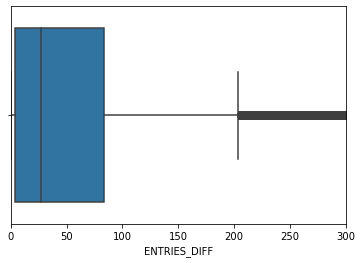

In [41]:
ent_plot = sns.boxplot(x=mta_df_values['ENTRIES_DIFF'])
ent_plot.set(xlim=(0, 300))

### But, there is a caveat here to use the box plot medthod in order to identify the outliers: By inspecting the data, it is obvious that the readings of the counters in different turnstiles is not happening in regular time slots. On the other hand it is very irregular. Let's look into this a bit further:

In [42]:
# Calculating the difference between the time of two consecutive readings for each turnstile:

time_diffs = mta_df_values.groupby(['TURNSTILE', 'STATION']).DATE_TIME.diff().reset_index()

In [43]:
time_diffs.head()

,index,DATE_TIME
0,0,NaT
1,1,0 days 04:00:00
2,2,0 days 04:00:00
3,3,0 days 04:00:00
4,4,0 days 04:00:00


In [44]:
# Converting the resulting differnce into seconds format:

time_diffs['time_seconds'] = time_diffs['DATE_TIME'] / np.timedelta64(1, 's')

In [45]:
time_diffs.head()

,index,DATE_TIME,time_seconds
0,0,NaT,NaN
1,1,0 days 04:00:00,14400.0
2,2,0 days 04:00:00,14400.0
3,3,0 days 04:00:00,14400.0
4,4,0 days 04:00:00,14400.0


In [46]:
# The list of unique time differences (first 10):

time_list = list(time_diffs.time_seconds.unique())
sorted(time_list, reverse=True)[0:10]

[nan,
 4162999.0,
 2493587.0,
 2220297.0,
 2145600.0,
 1873138.0,
 1773224.0,
 1742400.0,
 1555200.0,
 1440000.0]

### So irregular!

In [47]:
# Maximum time difference between two consecutive readings of a turnstile:

max(time_list[1:])

4162999.0

### This equals to 1156 hours or 48 days! Let's further inspect this turnstile:

In [48]:
time_diffs[time_diffs.time_seconds > 4162998.0]

,index,DATE_TIME,time_seconds
1650243,1650243,48 days 04:23:19,4162999.0


In [49]:
mta_df_values.iloc[1650220:1650270]

,TURNSTILE,STATION,DATE_TIME,DATE,TIME,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF
1650220,PTH18/R549/01-02-04,NEWARK BM BW,2021-08-31 21:04:29,08/31/2021,21:04:29,15177,668,31.0,2.0
1650221,PTH18/R549/01-02-04,NEWARK BM BW,2021-09-01 01:16:29,09/01/2021,01:16:29,15177,668,0.0,0.0
1650222,PTH18/R549/01-02-04,NEWARK BM BW,2021-09-01 05:28:29,09/01/2021,05:28:29,15190,669,13.0,1.0
1650223,PTH18/R549/01-02-04,NEWARK BM BW,2021-09-01 09:40:29,09/01/2021,09:40:29,15402,674,212.0,5.0
1650224,PTH18/R549/01-02-04,NEWARK BM BW,2021-09-01 13:52:29,09/01/2021,13:52:29,15417,680,15.0,6.0
1650225,PTH18/R549/01-02-04,NEWARK BM BW,2021-09-01 18:04:29,09/01/2021,18:04:29,15444,682,27.0,2.0
1650226,PTH18/R549/01-02-04,NEWARK BM BW,2021-09-01 22:16:29,09/01/2021,22:16:29,15456,683,12.0,1.0
1650227,PTH18/R549/01-02-04,NEWARK BM BW,2021-09-02 02:28:29,09/02/2021,02:28:29,15456,683,0.0,0.0
1650228,PTH18/R549/01-02-04,NEWARK BM BW,2021-09-02 06:40:29,09/02/2021,06:40:29,15508,688,52.0,5.0
1650229,PTH18/R549/01-02-04,NEWARK BM BW,2021-09-02 10:52:29,09/02/2021,10:52:29,15614,695,106.0,7.0


### The number of entries for this time interval is 30310, but it happened in the course of 48 days! If we want to filter the data by not taking into account the factor of time intervals, this data point might be an outlier, but if we also consider the time factor, it might fall into a reasonable range! 

### In order to avoid this error, we need to calculate the rate of entries and exits in the time intervals that they have been recorded and then move forward from there: 

In [50]:
mta_df_values['T_INTERVAL'] = time_diffs['DATE_TIME'] / np.timedelta64(1, 's')

In [51]:
mta_df_values.head()

,TURNSTILE,STATION,DATE_TIME,DATE,TIME,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF,T_INTERVAL
0,A002/R051/02-00-00,59 ST,2021-06-05 00:00:00,06/05/2021,00:00:00,7581941,2591624,0.0,0.0,NaN
1,A002/R051/02-00-00,59 ST,2021-06-05 04:00:00,06/05/2021,04:00:00,7581950,2591625,9.0,1.0,14400.0
2,A002/R051/02-00-00,59 ST,2021-06-05 08:00:00,06/05/2021,08:00:00,7581954,2591635,4.0,10.0,14400.0
3,A002/R051/02-00-00,59 ST,2021-06-05 12:00:00,06/05/2021,12:00:00,7582009,2591655,55.0,20.0,14400.0
4,A002/R051/02-00-00,59 ST,2021-06-05 16:00:00,06/05/2021,16:00:00,7582124,2591683,115.0,28.0,14400.0


In [52]:
# Calculating the rate of entries and exits:

mta_df_values['ENTRIES_RATE'] = mta_df_values['ENTRIES_DIFF'] / mta_df_values['T_INTERVAL']
mta_df_values['EXITS_RATE'] = mta_df_values['EXITS_DIFF'] / mta_df_values['T_INTERVAL']

In [53]:
mta_df_values.head()

,TURNSTILE,STATION,DATE_TIME,DATE,TIME,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF,T_INTERVAL,ENTRIES_RATE,EXITS_RATE
0,A002/R051/02-00-00,59 ST,2021-06-05 00:00:00,06/05/2021,00:00:00,7581941,2591624,0.0,0.0,NaN,NaN,NaN
1,A002/R051/02-00-00,59 ST,2021-06-05 04:00:00,06/05/2021,04:00:00,7581950,2591625,9.0,1.0,14400.0,0.000625,0.000069
2,A002/R051/02-00-00,59 ST,2021-06-05 08:00:00,06/05/2021,08:00:00,7581954,2591635,4.0,10.0,14400.0,0.000278,0.000694
3,A002/R051/02-00-00,59 ST,2021-06-05 12:00:00,06/05/2021,12:00:00,7582009,2591655,55.0,20.0,14400.0,0.003819,0.001389
4,A002/R051/02-00-00,59 ST,2021-06-05 16:00:00,06/05/2021,16:00:00,7582124,2591683,115.0,28.0,14400.0,0.007986,0.001944


In [54]:
mta_df_values.describe()

,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF,T_INTERVAL,ENTRIES_RATE,EXITS_RATE
count,2.722708e+06,2.722708e+06,2.722708e+06,2.722708e+06,2.717678e+06,2.717678e+06,2.717678e+06
mean,4.161933e+07,3.326199e+07,2.584682e+03,5.760472e+03,1.444698e+04,1.341987e-01,3.307396e-01
std,2.183449e+08,1.918266e+08,1.651251e+06,2.790162e+06,5.719439e+03,1.034094e+02,1.741797e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.184580e+05,1.006758e+05,4.000000e+00,6.000000e+00,1.440000e+04,2.777778e-04,4.166667e-04
50%,1.403842e+06,8.550550e+05,2.700000e+01,3.000000e+01,1.440000e+04,1.875000e-03,2.083333e-03
75%,6.016518e+06,3.970630e+06,8.400000e+01,8.900000e+01,1.440000e+04,5.833333e-03,6.250000e-03
max,2.147415e+09,2.133797e+09,1.889997e+09,2.133741e+09,4.162999e+06,1.312498e+05,1.481765e+05


### Now that we calculated the rates, we can go ahead and try to remove the outlieres using the IQR method:

[(0.0, 0.03)]

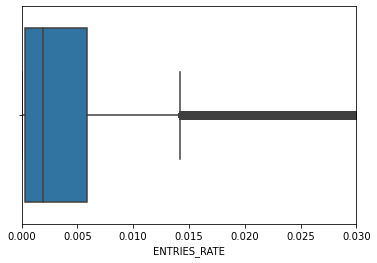

In [55]:
ent_rate_plot = sns.boxplot(x=mta_df_values['ENTRIES_RATE'])
ent_rate_plot.set(xlim=(0, 0.03))

### Seaborn calculates the length of the whiskers in a box plot by multiplying the interquartile range (IQR) by 1.5. So in order to determine and remove the outliers, we can use these codes below: 

In [56]:
# Calculating the IQR for the entries rates:

(stats.iqr(mta_df_values[['ENTRIES_RATE']].fillna(0)))
Q_3 = 0.00583

### Now let's take a look at the outliers that we found using this method: 

In [57]:
mta_df_values[(mta_df_values.ENTRIES_RATE > 
               (1.5*(stats.iqr(mta_df_values[['ENTRIES_RATE']].fillna(0), interpolation = 'midpoint')))+ Q_3)].head()

,TURNSTILE,STATION,DATE_TIME,DATE,TIME,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF,T_INTERVAL,ENTRIES_RATE,EXITS_RATE
17,A002/R051/02-00-00,59 ST,2021-06-07 20:00:00,06/07/2021,20:00:00,7583069,2592072,259.0,49.0,14400.0,0.017986,0.003403
23,A002/R051/02-00-00,59 ST,2021-06-08 20:00:00,06/08/2021,20:00:00,7583642,2592300,255.0,29.0,14400.0,0.017708,0.002014
29,A002/R051/02-00-00,59 ST,2021-06-09 20:00:00,06/09/2021,20:00:00,7584182,2592546,269.0,29.0,14400.0,0.018681,0.002014
35,A002/R051/02-00-00,59 ST,2021-06-10 20:00:00,06/10/2021,20:00:00,7584768,2592797,310.0,34.0,14400.0,0.021528,0.002361
41,A002/R051/02-00-00,59 ST,2021-06-11 20:00:00,06/11/2021,20:00:00,7585385,2593037,300.0,30.0,14400.0,0.020833,0.002083


### By looking at the table above, we see that a huge number of rows, around 7%, have been identified as outliers. By looking at the values and rates we see that some of them might be reasonable values and not an outlier. Why is this happening?  

### The answer lies in the nature of our data set. It is very common in subway systems across the world that in a few peak hours during the day, the traffic would be very high but at the rest of the day would be around a steady, much lower value. When we are using methods like the IQR or z-score, we are relying on values like mean or median which would be much closer to those lower steadier values. As a result the IQR or standard deviation that we calculate would be reliant on those values too, and this is exactly the reason that we may identify some of the peak hour values which are totally legitimate, as outliers. In order to avoid this, we need to find another criteria in order to determine our cut off threshold. 

### This threshold can be determined in a unique way for each data set that we are dealing with, depending on the nature of the data. In this particular case, our data points are the number of people who are passing subway turnstiles. There is a physical constraint on the maximum number of people who can pass a turnstile. If we make an educated guess on this number, we will be able to calculate the maximum number of people who can go through a turnstile in any given time interval and then treat all of the values more than that as an outlier. This is the method that we are going to use here.

### By the help of common sense, personal experiences with NYC subway system and some research, we determine the top rate of passing through a subway turnstile as 1 person in every 3 seconds for entry and 1 person in every 2 second at exit (no card swipe is required upon exit hence lower time). These rates have been determined very optimistically and we think that the actual rates might be much slower than these.

### Let's take a look at the rows with rates that are higher than our projected max rates:

In [58]:
# For entries:

mta_df_values[mta_df_values.ENTRIES_RATE > 1/3]

,TURNSTILE,STATION,DATE_TIME,DATE,TIME,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF,T_INTERVAL,ENTRIES_RATE,EXITS_RATE
30254,A014/R081/02-00-00,49 ST,2021-07-12 04:00:00,07/12/2021,04:00:00,14,6,67639.0,34360.0,14400.0,4.697153,2.386111
140570,A058/R001/01-00-01,WHITEHALL S-FRY,2021-06-19 17:00:00,06/19/2021,17:00:00,96,64,30702.0,25471.0,28800.0,1.066042,0.884410
176819,A084/R125/01-03-02,BROAD ST,2021-07-26 13:00:00,07/26/2021,13:00:00,5,0,150033.0,9739.0,14400.0,10.418958,0.676319
237240,B025/R150/00-00-01,AVENUE U,2021-07-23 17:00:00,07/23/2021,17:00:00,193,63,8049437.0,2357328.0,144000.0,55.898868,16.370333
324091,C025/R215/00-05-01,86 ST,2021-06-14 16:00:00,06/14/2021,16:00:00,458752,1,458728.0,72.0,360000.0,1.274244,0.000200
...,...,...,...,...,...,...,...,...,...,...,...,...
2695258,R728/R226/00-05-01,GUN HILL RD,2021-07-21 16:00:00,07/21/2021,16:00:00,262144,1,262144.0,22.0,144000.0,1.820444,0.000153
2701451,S101/R070/00-00-02,ST. GEORGE,2021-08-28 04:00:00,08/28/2021,04:00:00,1395861,324,182829.0,184.0,28800.0,6.348229,0.006389
2701453,S101/R070/00-00-02,ST. GEORGE,2021-08-28 12:00:00,08/28/2021,12:00:00,1213056,140,182818.0,184.0,14400.0,12.695694,0.012778
2701460,S101/R070/00-00-02,ST. GEORGE,2021-08-31 00:00:00,08/31/2021,00:00:00,1396117,324,182999.0,184.0,72000.0,2.541653,0.002556


In [59]:
# For exits:

mta_df_values[mta_df_values.EXITS_RATE > 1/2]

,TURNSTILE,STATION,DATE_TIME,DATE,TIME,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF,T_INTERVAL,ENTRIES_RATE,EXITS_RATE
30254,A014/R081/02-00-00,49 ST,2021-07-12 04:00:00,07/12/2021,04:00:00,14,6,6.763900e+04,34360.0,14400.0,4.697153,2.386111
140570,A058/R001/01-00-01,WHITEHALL S-FRY,2021-06-19 17:00:00,06/19/2021,17:00:00,96,64,3.070200e+04,25471.0,28800.0,1.066042,0.884410
176819,A084/R125/01-03-02,BROAD ST,2021-07-26 13:00:00,07/26/2021,13:00:00,5,0,1.500330e+05,9739.0,14400.0,10.418958,0.676319
237240,B025/R150/00-00-01,AVENUE U,2021-07-23 17:00:00,07/23/2021,17:00:00,193,63,8.049437e+06,2357328.0,144000.0,55.898868,16.370333
449043,H010/R235/01-03-01,BEDFORD AV,2021-08-27 12:00:00,08/27/2021,12:00:00,167790067,268473354,1.670878e+08,267390118.0,28800.0,5801.659549,9284.379097
...,...,...,...,...,...,...,...,...,...,...,...,...
2589672,R610/R057/00-03-02,ATL AV-BARCLAY,2021-06-21 08:00:00,06/21/2021,08:00:00,61,44,1.185151e+07,11825759.0,14400.0,823.021528,821.233264
2610042,R612/R057/01-05-00,ATL AV-BARCLAY,2021-07-07 16:00:00,07/07/2021,16:00:00,327681,0,5.001855e+07,134263112.0,28800.0,1736.755208,4661.913611
2621808,R621/R060/00-06-00,EASTN PKWY-MUSM,2021-08-26 12:00:00,08/26/2021,12:00:00,44,55,8.273600e+04,88440.0,14400.0,5.745556,6.141667
2654865,R633/R068/00-00-01,VAN SICLEN AV,2021-08-02 16:00:00,08/02/2021,16:00:00,23,29,6.481441e+06,2490055.0,14400.0,450.100069,172.920486


### A total 245 rows for entries and 212 rows for exits have that condition, less than 0.01% of the data! Let's go ahead and drop those values:  

In [60]:
# Dropping of the entry outliers:

mta_df_values.loc[mta_df_values.ENTRIES_RATE > 1/3, 'ENTRIES_DIFF'] = np.nan

In [61]:
# Dropping of the exit outliers:

mta_df_values.loc[mta_df_values.EXITS_RATE > 1/2, 'EXITS_DIFF'] = np.nan

### Now that the large outliers have been removed we can go ahead and remove the silent counters (the counters with no activity) as well:

In [62]:
# Finding the total activity of each counter (turnstile):

counters_total = mta_df_values.groupby(['TURNSTILE', 'STATION'])[['ENTRIES_DIFF', 
                                                                  'EXITS_DIFF']].sum().reset_index()

In [63]:
counters_total.head()

,TURNSTILE,STATION,ENTRIES_DIFF,EXITS_DIFF
0,A002/R051/02-00-00,59 ST,47421.0,18886.0
1,A002/R051/02-00-01,59 ST,34710.0,12231.0
2,A002/R051/02-03-00,59 ST,17605.0,71774.0
3,A002/R051/02-03-01,59 ST,45102.0,80038.0
4,A002/R051/02-03-02,59 ST,38163.0,54526.0


In [64]:
# Identifying the off entry counters:

off_entry_counters = counters_total[counters_total.ENTRIES_DIFF == 0]
off_entry_counters.head()

,TURNSTILE,STATION,ENTRIES_DIFF,EXITS_DIFF
10,A002/R051/02-05-01,59 ST,0.0,4.0
21,A007/R079/01-05-01,5 AV/59 ST,0.0,1.0
45,A011/R080/01-05-01,57 ST-7 AV,0.0,3.0
51,A013/R081/01-05-01,49 ST,0.0,4.0
186,A046/R463/00-05-01,CANAL ST,0.0,24.0


In [65]:
# Identifying the off exit counters:

off_exit_counters = counters_total[counters_total.EXITS_DIFF == 0]
off_exit_counters.head()

,TURNSTILE,STATION,ENTRIES_DIFF,EXITS_DIFF
9,A002/R051/02-05-00,59 ST,31.0,0.0
20,A007/R079/01-05-00,5 AV/59 ST,10.0,0.0
44,A011/R080/01-05-00,57 ST-7 AV,24.0,0.0
50,A013/R081/01-05-00,49 ST,17.0,0.0
185,A046/R463/00-05-00,CANAL ST,83.0,0.0


In [66]:
# Creating CSV files from the off counters for future use:

off_entry_counters.to_csv('off_entry_counters.csv')
off_exit_counters.to_csv('off_exit_counters.csv')

In [67]:
# Dropping the 0 diff for off entry counters:

for turnstile in off_entry_counters['TURNSTILE']:
    mta_df_values.loc[mta_df_values.TURNSTILE == turnstile, 'ENTRIES_DIFF'] = np.nan

In [68]:
# Dropping the 0 diff for off exit counters:

for turnstile in off_exit_counters['TURNSTILE']:
    mta_df_values.loc[mta_df_values.TURNSTILE == turnstile, 'EXITS_DIFF'] = np.nan

### Now, because we manipulated the two diff columns in removing outliers and off counters, we have to recalculate the rate columns as they are not being automatically updated:

In [69]:
# Removing the old rate columns:

mta_df_values.drop(columns=['ENTRIES_RATE', 'EXITS_RATE'], inplace=True)

In [70]:
# Calculating the new rate columns:

mta_df_values['ENTRIES_RATE'] = mta_df_values['ENTRIES_DIFF'] / mta_df_values['T_INTERVAL']
mta_df_values['EXITS_RATE'] = mta_df_values['EXITS_DIFF'] / mta_df_values['T_INTERVAL']

In [71]:
mta_df_values.head()

,TURNSTILE,STATION,DATE_TIME,DATE,TIME,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF,T_INTERVAL,ENTRIES_RATE,EXITS_RATE
0,A002/R051/02-00-00,59 ST,2021-06-05 00:00:00,06/05/2021,00:00:00,7581941,2591624,0.0,0.0,NaN,NaN,NaN
1,A002/R051/02-00-00,59 ST,2021-06-05 04:00:00,06/05/2021,04:00:00,7581950,2591625,9.0,1.0,14400.0,0.000625,0.000069
2,A002/R051/02-00-00,59 ST,2021-06-05 08:00:00,06/05/2021,08:00:00,7581954,2591635,4.0,10.0,14400.0,0.000278,0.000694
3,A002/R051/02-00-00,59 ST,2021-06-05 12:00:00,06/05/2021,12:00:00,7582009,2591655,55.0,20.0,14400.0,0.003819,0.001389
4,A002/R051/02-00-00,59 ST,2021-06-05 16:00:00,06/05/2021,16:00:00,7582124,2591683,115.0,28.0,14400.0,0.007986,0.001944


In [72]:
mta_df_values.describe()

,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF,T_INTERVAL,ENTRIES_RATE,EXITS_RATE
count,2.722708e+06,2.722708e+06,2.584025e+06,2.577205e+06,2.717678e+06,2.579266e+06,2.572450e+06
mean,4.161933e+07,3.326199e+07,6.403738e+01,7.443583e+01,1.444698e+04,4.452758e-03,5.169026e-03
std,2.183449e+08,1.918266e+08,1.232193e+02,1.860142e+02,5.719439e+03,6.087114e-03,7.749011e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.184580e+05,1.006758e+05,6.000000e+00,8.000000e+00,1.440000e+04,4.166667e-04,5.555556e-04
50%,1.403842e+06,8.550550e+05,3.100000e+01,3.400000e+01,1.440000e+04,2.152778e-03,2.361111e-03
75%,6.016518e+06,3.970630e+06,8.800000e+01,9.500000e+01,1.440000e+04,6.180556e-03,6.597222e-03
max,2.147415e+09,2.133797e+09,6.955400e+04,1.230080e+05,4.162999e+06,3.284673e-01,4.441800e-01


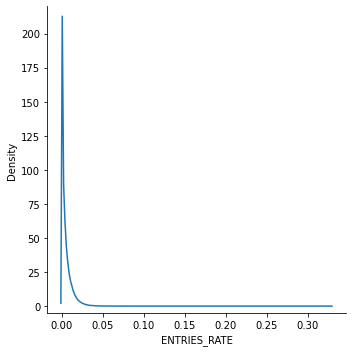

In [73]:
# Plotting the distribution of the entry rates:

entries_rate_dist = sns.displot(data=mta_df_values, x="ENTRIES_RATE", kind="kde")
entries_rate_dist.set(ylim=(-5, 220))

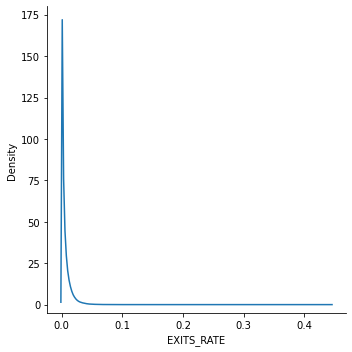

In [74]:
# Plotting the distribution of the exit rates:

exits_rate_dist = sns.displot(data=mta_df_values, x="EXITS_RATE", kind="kde")
exits_rate_dist.set(ylim=(-5, 180))

In [75]:
mta_df_values.to_csv('mta_df_clean_noline.csv')

### At this point the data is clean and we can move forward to the rest of the analysis!